In [32]:
#! /bin/python3.7
#! pip install fastai
#! pip install torchaudio==0.7
#! pip install librosa

In [33]:
from fastai.vision.all import *
import pathlib
import librosa
from IPython.display import Audio
import librosa.display
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

In [34]:
mypath = "/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = get_files(mypath, extensions='.wav')
filenames

(#920) [Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/223_1b1_Ar_sc_Meditron.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/133_2p2_Tc_mc_AKGC417L.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/109_1b1_Pl_sc_Litt3200.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Pr_sc_Litt3200.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/188_1b1_Tc_sc_Meditron.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/203_1p3_Ar_mc_AKGC417L.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound

In [35]:
p_diag = pd.read_csv("/home/john/Downloads/kaggle_respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file
p_diag.head()

,0,1
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [36]:
# configuration for audio processing
n_fft=1024
hop_length=256
target_rate=44100
num_samples=int(target_rate)

In [37]:
## Method for labelling sample (Healthy/Unhealthy)
def get_y(path): 
    desease = p_diag[p_diag[0] == int(path.stem[:3])][1].values[0]
    if desease == "Healthy":
        return "Healthy"
    else : 
        return "Unhealthy"

In [38]:
## Method for getting all audio files, I get file withc rate 44100 Hz only because resampling take so much time :( 
def get_items(path): 
    fns = [fn for fn in get_files(path, extensions='.wav') if torchaudio.load_wav(fn)[1] == target_rate]
    return fns

In [39]:
## Helper method to tranform audio array to Spectrogram
au2spec = torchaudio.transforms.MelSpectrogram(sample_rate=target_rate,n_fft=n_fft, hop_length=hop_length, n_mels=256)
ampli2db = torchaudio.transforms.AmplitudeToDB()

In [40]:
def get_x(path, target_rate=target_rate, num_samples=num_samples*2):
    x, rate = torchaudio.load_wav(path)
    if rate != target_rate: 
        x = torchaudio.transforms.Resample(orig_freq=rate, new_freq=target_rate, resampling_method='sinc_interpolation')(x)
    x = x[0] / 32768
    x = x.numpy()
    sample_total = x.shape[0]
    randstart = random.randint(target_rate, sample_total-target_rate*3)
    x = x[randstart:num_samples+randstart]
    x = librosa.util.fix_length(x, num_samples)
    torch_x = torch.tensor(x)
    spec = au2spec(torch_x)
    spec_db = ampli2db(spec)
    spec_db = spec_db.data.squeeze(0).numpy()
    spec_db = spec_db - spec_db.min()
    spec_db = spec_db/spec_db.max()*255
    return spec_db

In [41]:
print(torch.__version__)
print(torchaudio.__version__)

1.7.1
0.7.0


In [42]:
## Getting all files and labels
items = get_items(mypath)
labels = [get_y(item) for item in items]
Counter(labels)

Counter({'Unhealthy': 789, 'Healthy': 35})

In [43]:
test_size=0.3
x_train, x_test, y_train, y_test = train_test_split(items, labels, stratify=labels, 
                                                    test_size=test_size, random_state = 42)

In [44]:
num_rows = 40
num_columns = 862
num_channels = 1
num_labels = labels
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [45]:
test_size=0.3
splitter = TrainTestSplitter(test_size=test_size, random_state=42, stratify=labels)


In [46]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms=[Resize(256)])


In [47]:
dsets = db.datasets(items)

In [48]:

dsets

(#824) [(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1))...]

In [49]:
count = Counter(labels)
wgts = [1/count[dsets.vocab[label]] for img, label in dsets.train]
wgts[:10]

[0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.02857142857142857,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308]

In [51]:
dls = db.dataloaders(items, num_workers=2, dl_type=WeightedDL, wgts=wgts)


In [52]:
x, y = dls.one_batch()

In [53]:
sum(y)/len(y)
## ~50% => we are fine here

tensor(0.5312)

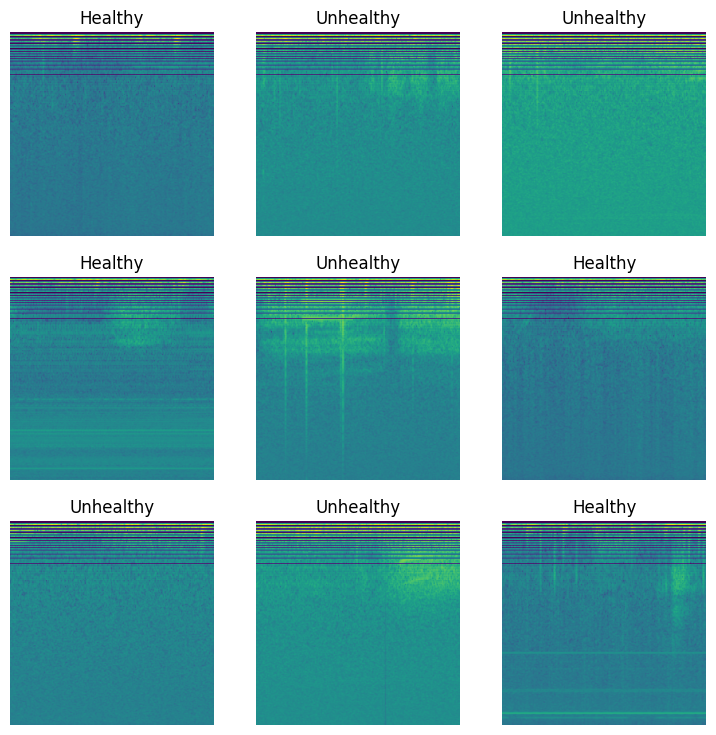

In [54]:

dls.show_batch()

In [58]:

## We use xresnet18 as model
learn = cnn_learner(dls, xresnet18, metrics=[accuracy,error_rate])
# learn = cnn_learner(dls, models.resnet50, metrics=error_rate)

In [59]:
## model learning
learn.fine_tune(1)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[64, 1, 256, 256] to have 3 channels, but got 1 channels instead

In [ ]:

learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)